Podstawy Gymnasium

In [48]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pickle
from typing import Tuple
import random

In [49]:
class WalkingCliff:
    def __init__(
            self,
            env: gym.Env,
            learning_rate: float,
            initial_epsilon: float,
            epsilon_decay: float,
            final_epsilon: float,
            discount_factor: float = 0.9,
            is_train: bool = True,
    ):
        """Initialize a Reinforcement Learning agent with an empty numpy array (q_values), a learning rate and an epsilon.

        Args:
            env: The training environment
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value, measures the importance of future rewards.
            is_train: Whether the agent is in training mode or not.
        """
        self.env = env


        if is_train:
            self.q_values = np.zeros((env.observation_space.n, env.action_space.n))
        else:
            with open('walking_cliff_model.pkl', 'rb') as f:
                self.q_values = pickle.load(f)


        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.is_train = is_train

    def get_action(self, observation):
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        if np.random.random() < self.epsilon and self.is_train:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.q_values[observation])

    def update(self, observation, action, reward, terminated, next_observation):
        """Updates the Q-value of an action."""
        # Observation Space: Box([-1.2 -0.07], [0.6 0.07], (2,), float32)
        future_q_value = (not terminated) * np.max(self.q_values[next_observation])

        temporal_difference = (
                reward + self.discount_factor * future_q_value - self.q_values[observation][action]
        )

        self.q_values[observation][action] = (
                self.q_values[observation][action] + self.lr * temporal_difference
        )


    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)



In [50]:
def run_agent(agent, env, n_episodes):

  for episode in (range(n_episodes)):
      obs, info = env.reset()
      done = False

      # play one episode
      while not done:
          action = agent.get_action(obs)
          next_obs, reward, terminated, truncated, info = env.step(action)


          if agent.is_train:
              # update the agent
              agent.update(obs, action, reward, terminated, next_obs)

          # update if the environment is done and the current obs
          done = terminated or truncated
          obs = next_obs

      agent.decay_epsilon()




In [51]:
def plot_results(env, is_train, rolling_length=500):

  def get_moving_avgs(arr, window, convolution_mode):
      return np.convolve(
          np.array(arr).flatten(),
          np.ones(window),
          mode=convolution_mode
      ) / window

  # Smooth over a 500 episode window
  rolling_length = 500
  fig, axs = plt.subplots(ncols=2, figsize=(12, 5))

  axs[0].set_title("Episode rewards")
  reward_moving_average = get_moving_avgs(
      env.return_queue,
      rolling_length,
      "valid"
  )
  axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
  axs[0].axhline(y=-13, color='red', linestyle='--')


  axs[1].set_title("Episode lengths")
  length_moving_average = get_moving_avgs(
      env.length_queue,
      rolling_length,
      "valid"
  )
  axs[1].plot(range(len(length_moving_average)), length_moving_average)

  plt.tight_layout()
  plt.savefig(f"cliff_{'train' if is_train else 'test'}.png")

  plt.show()

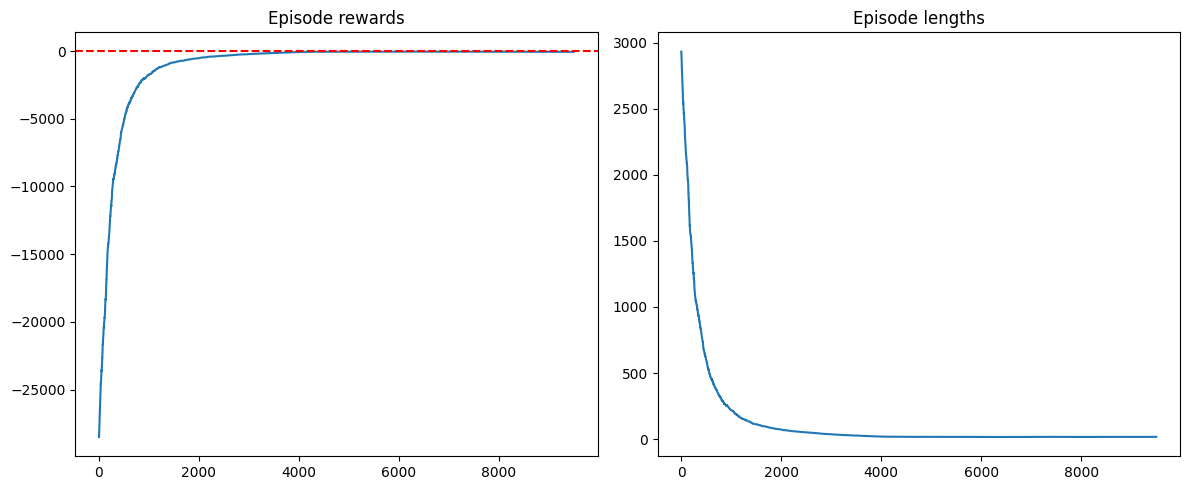

In [52]:
# hyperparameters
learning_rate = 0.01
n_train_episodes = 10_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_train_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1


env_train = gym.make('CliffWalking-v0')
env_train = gym.wrappers.RecordEpisodeStatistics(env_train, buffer_length=n_train_episodes)

agent_train = WalkingCliff(
    env=env_train,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    is_train= True
)

run_agent(agent_train, env_train, n_train_episodes)

if agent_train.is_train:
    with open('walking_cliff_model.pkl', 'wb') as f:
        pickle.dump(agent_train.q_values, f)

plot_results(env_train, agent_train.is_train)


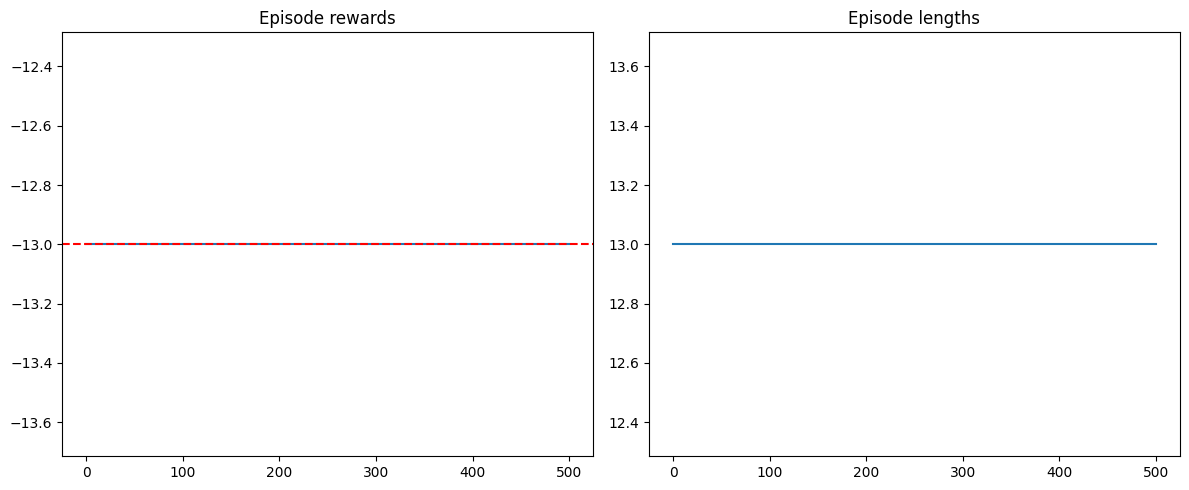

In [53]:
n_test_episodes = 1000

env_test = gym.make('CliffWalking-v0')
env_test = gym.wrappers.RecordEpisodeStatistics(env_test, buffer_length=n_test_episodes)

agent_test = WalkingCliff(
    env=env_test,
    learning_rate=learning_rate,
    initial_epsilon=0.0,
    epsilon_decay=0.0,
    final_epsilon=0.0,
    is_train=False
)

run_agent(agent_test, env_test, n_test_episodes)
plot_results(env_test, False)


zadanie za 6 punktów

In [58]:
class MountainCar:
    def __init__(
            self,
            env: gym.Env,
            n_bins: Tuple[int, int],
            learning_rate: float,
            initial_epsilon: float,
            epsilon_decay: float,
            final_epsilon: float,
            discount_factor: float = 0.9,
            is_train: bool = True,
            discrete_actions: np.ndarray = np.array([-1.0, 0.0, 1.0])
    ):
        """Initialize a Reinforcement Learning agent with an empty numpy array (q_values), a learning rate and an epsilon.

        Args:
            env: The training environment
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value, measures the importance of future rewards.
            is_train: Whether the agent is in training mode or not.
        """
        self.env = env
        self.n_bins = n_bins
        self.lr = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.is_train = is_train
        self.discrete_actions = discrete_actions
        self.action_space_size = len(discrete_actions)

        self.obs_low = env.observation_space.low
        self.obs_high = env.observation_space.high
        self.discrete_state_space_size = n_bins[0] * n_bins[1]

        if is_train:
            self.q_values = np.zeros((self.discrete_state_space_size, self.discrete_state_space_size))
        else:
            with open('mountain_car_model.pkl', 'rb') as f:
                self.q_values = pickle.load(f)

    def discretize_observation(self, observation):
        """Discretizes the continuous observation into a state index."""
        ratios = (observation - self.obs_low) / (self.obs_high - self.obs_low)
        scaled_obs = np.round(ratios * (np.array(self.n_bins) - 1)).astype(int)
        return np.ravel_multi_index(scaled_obs, self.n_bins)

    def get_action(self, observation):
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        discrete_state = self.discretize_observation(observation)
        if np.random.random() < self.epsilon and self.is_train:
            return random.choice(range(self.action_space_size))
        else:
            return np.argmax(self.q_values[discrete_state])

    def get_continuous_action(self, action_index):
        """Maps the discrete action index to the actual continuous action value."""
        return self.discrete_actions[action_index]

    def update(self, observation, action, reward, terminated, next_observation):
        """Updates the Q-value of an action."""
        discrete_state = self.discretize_observation(observation)
        next_discrete_state = self.discretize_observation(next_observation)

        future_q_value = (not terminated) * np.max(self.q_values[next_discrete_state])

        temporal_difference = (
                reward + self.discount_factor * future_q_value - self.q_values[discrete_state][action]
        )

        self.q_values[discrete_state][action] = (
                self.q_values[discrete_state][action] + self.lr * temporal_difference
        )


    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)



In [69]:
def run_agent_discretized(agent, env, n_episodes, gamma):
    episode_rewards = []
    for episode in range(n_episodes):
        obs, info = env.reset()
        done = False
        total_reward = 0

        while not done:
            action_index = agent.get_action(obs)
            continuous_action = agent.get_continuous_action(action_index)
            next_obs, reward, terminated, truncated, info = env.step([continuous_action])
            total_reward += reward

            if agent.is_train:
                agent.update(obs, action_index, reward, terminated, next_obs)

            done = terminated or truncated
            obs = next_obs

        agent.decay_epsilon()
        episode_rewards.append(total_reward)
        # print(f"Gamma: {gamma:.2f}, Episode {episode + 1}/{n_episodes}, Reward: {total_reward}, Epsilon: {agent.epsilon:.2f}")
    return episode_rewards

In [70]:
def plot_comparison(all_rewards, discount_factors, rolling_length=200):
    def get_moving_avgs(arr, window):
        return np.convolve(arr, np.ones(window), 'valid') / window

    plt.figure(figsize=(10, 6))
    for rewards, gamma in zip(all_rewards, discount_factors):
        moving_avg = get_moving_avgs(rewards, rolling_length)
        plt.plot(moving_avg, label=f'Gamma = {gamma:.2f}')

    plt.xlabel('Episodes')
    plt.ylabel(f'Moving Average of Episode Rewards (Window: {rolling_length})')
    plt.title('Comparison of Discount Factors on MountainCarContinuous')
    plt.legend()
    plt.grid(True)
    plt.savefig('mountain_car_gamma_comparison.png')
    plt.show()

In [71]:
def plot_results_discretized(env, is_train, rolling_length=500):
    def get_moving_avgs(arr, window, convolution_mode):
        return np.convolve(
            np.array(arr).flatten(),
            np.ones(window),
            mode=convolution_mode
        ) / window

    fig, axs = plt.subplots(ncols=2, figsize=(12, 5))

    axs[0].set_title("Episode rewards")
    reward_moving_average = get_moving_avgs(
        env.return_queue,
        rolling_length,
        "valid"
    )
    axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
    axs[0].axhline(y=-13, color='red', linestyle='--')

    axs[1].set_title("Episode lengths")
    length_moving_average = get_moving_avgs(
        env.length_queue,
        rolling_length,
        "valid"
    )
    axs[1].plot(range(len(length_moving_average)), length_moving_average)

    plt.tight_layout()
    plt.savefig(f"mountain_car_continuous_discretized_{'train' if is_train else 'test'}.png")
    plt.show()


Training agent with Discount Factor: 0.70

Training agent with Discount Factor: 0.90

Training agent with Discount Factor: 0.99


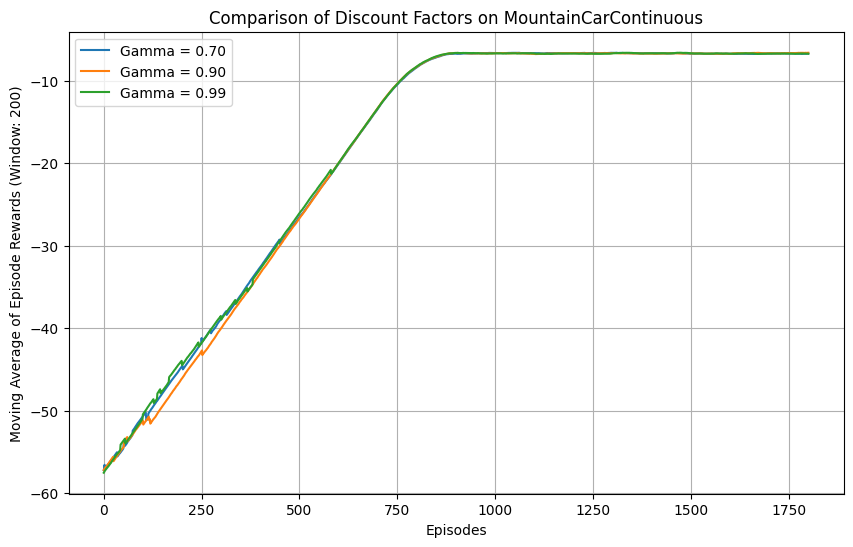

In [72]:
# hyperparameters
learning_rate = 0.01
n_train_episodes = 2000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_train_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1
n_bins = (18, 14)
discrete_actions = np.array([-1.0, 0.0, 1.0])
discount_factors_to_test = [0.7, 0.9, 0.99]
all_episode_rewards = []

env_discretized_train = gym.make("MountainCarContinuous-v0")  # default goal_velocity=0
for gamma in discount_factors_to_test:
    print(f"\nTraining agent with Discount Factor: {gamma:.2f}")
    env_train = gym.wrappers.RecordEpisodeStatistics(env_discretized_train, buffer_length=n_train_episodes)
    agent_train = MountainCar(
        env=env_train,
        n_bins=n_bins,
        learning_rate=learning_rate,
        initial_epsilon=start_epsilon,
        epsilon_decay=epsilon_decay,
        final_epsilon=final_epsilon,
        discount_factor=gamma,
        is_train=True,
        discrete_actions=discrete_actions
    )

    rewards = run_agent_discretized(agent_train, env_train, n_train_episodes, gamma)
    all_episode_rewards.append(rewards)

    if agent_train.is_train:
        with open(f'mountain_car_continuous_discretized_model_gamma_{gamma:.2f}.pkl', 'wb') as f:
            pickle.dump(agent_train.q_values, f)

env_discretized_train.close()
plot_comparison(all_episode_rewards, discount_factors_to_test)


Testing the trained agents:

Testing agent trained with Gamma: 0.70

Testing agent trained with Gamma: 0.90

Testing agent trained with Gamma: 0.99


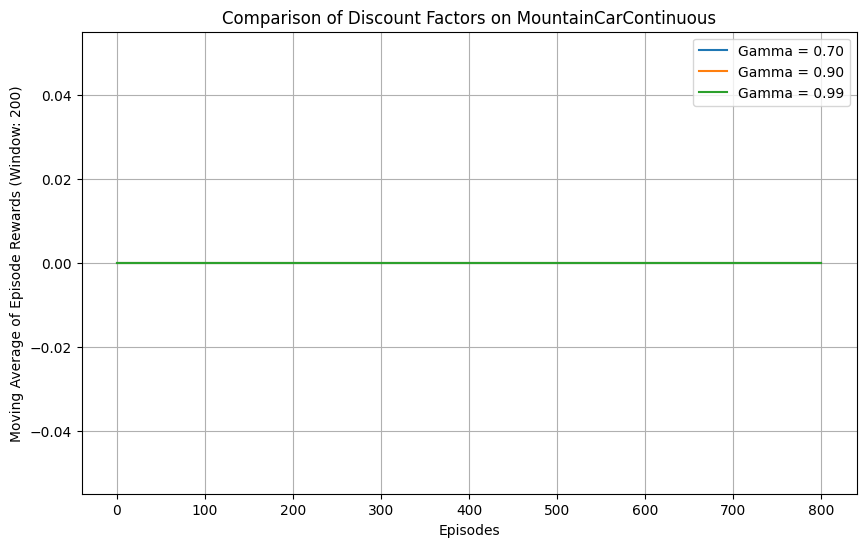

In [73]:
n_test_episodes = 1000
all_test_episode_rewards = []

print("\nTesting the trained agents:")
for gamma in discount_factors_to_test:
    print(f"\nTesting agent trained with Gamma: {gamma:.2f}")
    env_test = gym.make('MountainCarContinuous-v0')
    env_test = gym.wrappers.RecordEpisodeStatistics(env_test, buffer_length=n_test_episodes)

    agent_test = MountainCar(
        env=env_test,
        n_bins=n_bins,
        learning_rate=learning_rate,
        initial_epsilon=0.0,
        epsilon_decay=0.0,
        final_epsilon=0.0,
        discount_factor=gamma,
        is_train=False,
        discrete_actions=discrete_actions
    )

    test_rewards = run_agent_discretized(agent_test, env_test, n_test_episodes, gamma)
    all_test_episode_rewards.append(test_rewards)
    env_test.close()

plot_comparison(all_test_episode_rewards, discount_factors_to_test, rolling_length=200)